# Computational Cost Trends

This notebook investigates the computational cost trends for several stages of
the BPSCAN algorithm.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from biperscan import BPSCAN

from lib.plotting import *

palette = configure_matplotlib()

In [3]:
X = np.load("data/flared/flared_clusterable_data.npy")

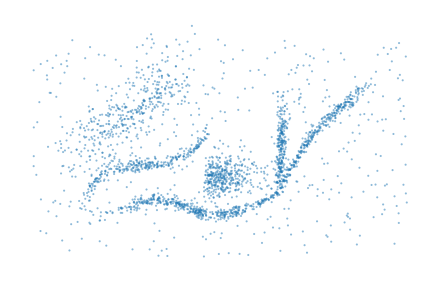

In [4]:
sized_fig(0.5)
scatter_kwargs = dict(s=1, alpha=0.5, linewidths=0, edgecolor="none")
plt.scatter(*X.T,**scatter_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.show()

In [5]:
from tqdm.contrib.itertools import product

repeats = 5
fractions = [1 / 16, 1 / 8, 1 / 4, 1 / 2, 1]
sizes = [int(f * X.shape[0]) for f in fractions]

timers = []
for i, size in product(range(repeats), sizes):
    indices = np.random.choice(X.shape[0], size, replace=False)
    X_sample = X[indices]
    c = BPSCAN(min_samples=5, min_cluster_size=20, distance_fraction=0.5).fit(X_sample)
    c.timers_["size"] = size
    timers.append(c.timers_)

times = pd.DataFrame.from_records(timers)

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
times.groupby('size').mean().T

size,158,316,632,1264,2529
distances,0.000456,0.000708,0.001629,0.004881,0.015795
lens_values,0.000104,0.000079,0.000090,0.000135,0.000220
matrix,0.001736,0.008527,0.041231,0.212885,1.276946
minpres,0.001650,0.009829,0.068491,0.475943,2.664567
merges,0.000255,0.000579,0.001696,0.004406,0.011983
simplify,0.000191,0.000327,0.000821,0.001366,0.002862
labels,0.000161,0.000140,0.000269,0.000434,0.000879


Cumulative time indicating algorithm progress:

In [7]:
stage_order = [
    "lens_values",
    "distances",
    "matrix",
    "minpres",
    "merges",
    "simplify",
    "labels",
]
names = [
    "lens values",
    "distances",
    "boundary matrix",
    "minimal presentation",
    "cluster merges",
    "hierarchy simplification",
    "cluster labels",
]
cumulative_times = times.copy()
cumulative_times[stage_order] = np.cumsum(times[stage_order], axis=1)

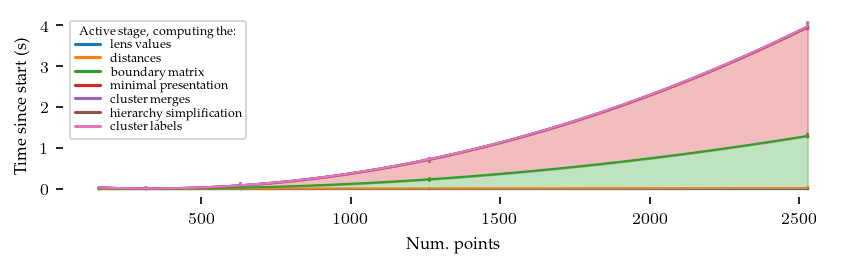

In [8]:
from matplotlib.lines import Line2D

sized_fig(1, aspect=0.618/2)

for i, col in enumerate(stage_order):
    sns.regplot(
        cumulative_times.melt(
            id_vars=["size"], value_vars=[col], var_name="stage", value_name="time"
        ),
        x="size",
        y="time",
        order=2,
        color=f"C{i}",
        ci=None,
        line_kws={"linewidth": 1},
        scatter_kws=dict(edgecolor="none", linewidths=0, s=2),
    )
adjust_legend_subtitles(
    plt.legend(
        title="Active stage, computing the:",
        handles=[
            Line2D([], [], color=f"C{i}", label=k.replace("_", " "))
            for i, k in enumerate(names)
        ],
        labelspacing=0.1,
    ),
)
lines = plt.gca().lines
plt.fill_between(
    x=lines[0].get_xdata(),
    y1=lines[0].get_ydata(),
    color=f"C{0}",
    alpha=.3,
)
for i, (l1, l2) in enumerate(zip(lines[:-1], lines[1:])):
    plt.fill_between(
        x=l1.get_xdata(),
        y1=l1.get_ydata(),
        y2=l2.get_ydata(),
        color=f"C{i+1}",
        alpha=.3,
    )
plt.xlabel("Num. points")
plt.ylabel("Time since start (s)")
plt.subplots_adjust(0.07, 0.23, 1.02, 0.95)
plt.savefig("images/benchmark_flareable.pdf", pad_inches=0)
plt.show()

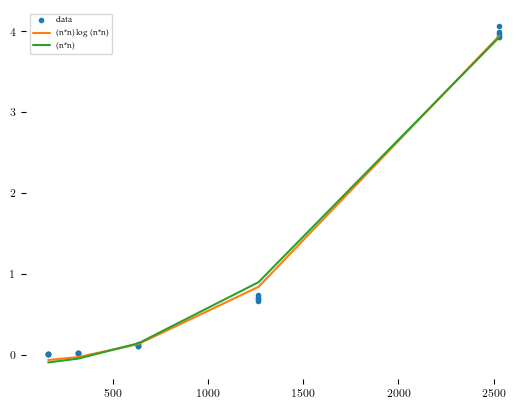

In [9]:
totals = cumulative_times[["size", "labels"]]
xs = totals["size"].to_numpy()
ys = totals.labels.to_numpy()

uxs = np.unique(xs)

plt.plot(xs, ys, ".", label="data")
coefficients = np.polyfit(xs**2 * np.log(xs**2), ys, 1)
fit = np.poly1d(coefficients)
plt.plot(uxs, fit(uxs**2 * np.log(uxs**2)), "-", label="(n*n) log (n*n)")
coefficients = np.polyfit(xs**2, ys, 1)
fit = np.poly1d(coefficients)
plt.plot(uxs, fit(uxs**2), "-", label="(n*n)")
plt.legend()
plt.show()

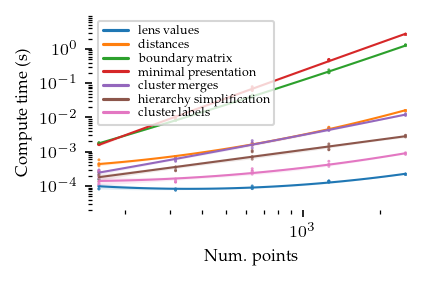

In [10]:
from matplotlib.ticker import FixedLocator

sized_fig(0.5)
for i, col in enumerate(stage_order):
    vals = times.melt(
            id_vars=["size"], value_vars=[col], var_name="stage", value_name="time"
        )
    sns.regplot(
        x=np.log10(vals['size']),
        y=np.log10(vals["time"]),
        order=2,
        color=f"C{i}",
        line_kws={"linewidth": 1},
        scatter_kws=dict(edgecolor="none", linewidths=0, s=2),
    )
adjust_legend_subtitles(
    plt.legend(
        # title="Algorithm stage",
        handles=[Line2D([], [], color=f"C{i}", label=k) for i, k in enumerate(names)],
        # ncols=2,
        labelspacing=0.1,
        # columnspacing=0.7,
    ),
)
plt.xlabel("Num. points")
plt.ylabel("Compute time (s)")


x_ticks = np.arange(2, 4)
plt.gca().set_xticks(x_ticks)
plt.gca().get_xaxis().set_major_formatter(lambda x, pos: "$10^{" + f"{x:d}" + "}$")
plt.gca().get_xaxis().set_minor_locator(
    FixedLocator(locs=np.concat((
        np.log10(np.arange(2, 10) * 10.0 ** (x_ticks[0] - 1)),
        np.log10(np.arange(2, 10) * 10.0 ** x_ticks[None].T).ravel())
    ))
)

x_ticks = np.arange(2, 4)
plt.gca().set_xticks(x_ticks)
plt.gca().get_xaxis().set_major_formatter(lambda x, pos: "$10^{" + f"{x:d}" + "}$")
plt.gca().get_xaxis().set_minor_locator(
    FixedLocator(locs=np.concat((
        np.log10(np.arange(2, 10) * 10.0 ** (x_ticks[0] - 1)),
        np.log10(np.arange(2, 10) * 10.0 ** x_ticks[None].T).ravel())
    ))
)

y_ticks = np.arange(-4, 1)

plt.gca().set_yticks(y_ticks)
plt.gca().get_yaxis().set_major_formatter(lambda x, pos: "$10^{" + f"{x:d}" + "}$") #f"{10.0 ** x:g}")
plt.gca().get_yaxis().set_minor_locator(
    FixedLocator(locs=np.concat((
        np.log10(np.arange(2, 10) * 10.0 ** (y_ticks[0] - 1)),
        np.log10(np.arange(2, 10) * 10.0 ** y_ticks[None].T).ravel())
    ))
)

plt.xlim(np.log10([sizes[0]-10, sizes[-1]+100]))
plt.ylim(np.log10([2e-5, 10]))
plt.show()